train autoencoder WITHOUT using 1DCNN roi finder

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from PyPDF2 import PdfMerger
import os
from tensorflow.keras.models import load_model

2023-06-03 16:21:44.558821: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-03 16:21:44.560782: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 16:21:44.593700: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 16:21:44.594346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 16:21:45.142486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
wireplane = "V"
np.random.seed(77)
path = '/home/vlian/Workspace/processed_data_LATEST/'

In [3]:
def load_data(path, wireplane):
    x_train = np.load(path+'x_train_' + wireplane + '.npy')
    x_test = np.load(path+'x_test_' + wireplane + '.npy')
    y_train = np.load(path+'y_train_AE_' + wireplane + '.npy')
    y_test = np.load(path+'y_test_AE_' + wireplane + '.npy')
    
    #split train and valid sets (40k train 10k valid) 
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_train, y_train, test_size=0.2, shuffle=True
    )
    
    mean = x_train.mean()
    std = x_train.std()

    x_train_scaled = (x_train-mean)/std
    x_test_scaled = (x_test-mean)/std
    x_valid_scaled = (x_valid-mean)/std
    
    y_train_scaled = (y_train-mean)/std
    y_test_scaled = (y_test-mean)/std
    y_valid_scaled = (y_valid-mean)/std

    return x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_valid_scaled, y_valid_scaled, mean, std

In [4]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_valid_scaled, y_valid_scaled, mean, std = load_data(path, wireplane)

In [5]:
np.save('./models/mean_baseAE_'+wireplane, mean)
np.save('./models/std_baseAE_'+wireplane, std)

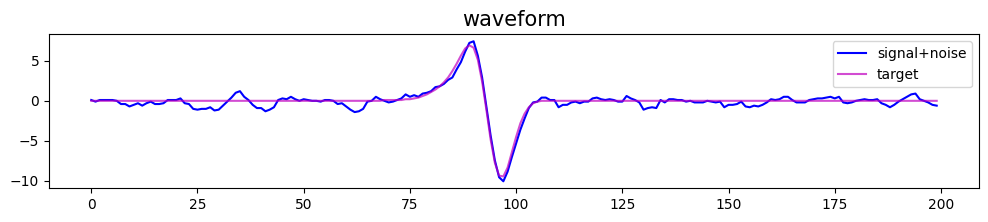

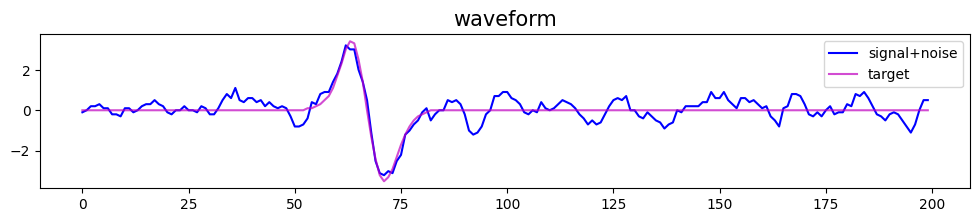

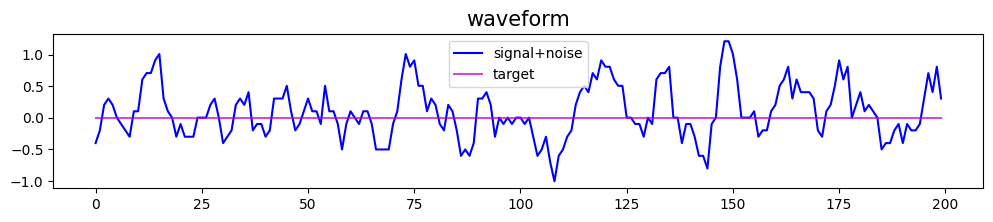

In [6]:
for idx in range(6,9):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(x_train_scaled[idx],color='blue', label='signal+noise')
    ax1.plot(y_train_scaled[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()

    plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization
#from keras import backend as K

In [8]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1DTranspose

In [9]:
from tensorflow.keras.models import load_model
cnn_roi_finder = load_model('../ROI_finder/ROI_models/model_'+wireplane+'plane_nu_ROI.h5')

In [10]:
for i,layer in enumerate(cnn_roi_finder.layers):
  print(i,layer.name)

0 conv1d
1 max_pooling1d
2 conv1d_1
3 max_pooling1d_1
4 dropout
5 conv1d_2
6 global_max_pooling1d
7 dropout_1
8 flatten
9 wavrec_out


In [11]:
time_periods = 200
input_wave = Input(shape=(time_periods, 1)) 
x = Conv1D(filters=16, kernel_size=3, strides=2, activation="relu", weights=cnn_roi_finder.layers[0].get_weights(), input_shape=(time_periods,1))(input_wave)
x = MaxPooling1D(pool_size=2)(x)
 
# second convolutional block
x = Conv1D(filters=32, kernel_size=5, strides=2,weights=cnn_roi_finder.layers[2].get_weights(), activation="relu")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv1D(filters=64, kernel_size=9, strides=1, weights=cnn_roi_finder.layers[5].get_weights(), activation="relu")(x)

x = GlobalMaxPooling1D()(x)

x = Dropout(0.2)(x)

encoded = Reshape((1, x.shape[1]), name='encoded')(x)


x = UpSampling1D(size=3)(encoded)


# first deconvolutional block
x = Conv1DTranspose(filters=64, kernel_size=9, strides =1, activation="relu")(x)
x = UpSampling1D(size=2)(x)

x = Dropout(0.1)(x)

# second deconvolutional block
x = Conv1DTranspose(filters=32, kernel_size=5, strides=2, activation="relu")(x)

x = UpSampling1D(size=2)(x) # increase the size to match the encoder

decoded = Conv1DTranspose(filters=16, kernel_size=3, strides=2, activation="relu")(x)
decoded = Conv1DTranspose(filters=1, kernel_size=12, strides=1)(decoded)
autoencoder = Model(input_wave, decoded)


In [12]:
for i,layer in enumerate(autoencoder.layers):                                      
  print(i,layer.name)

0 input_1
1 conv1d
2 max_pooling1d
3 conv1d_1
4 max_pooling1d_1
5 dropout
6 conv1d_2
7 global_max_pooling1d
8 dropout_1
9 encoded
10 up_sampling1d
11 conv1d_transpose
12 up_sampling1d_1
13 dropout_2
14 conv1d_transpose_1
15 up_sampling1d_2
16 conv1d_transpose_2
17 conv1d_transpose_3


In [13]:
# see what happens when we unfreeze more layers of the 1dcnn
for layer in autoencoder.layers[:9]:                                               
    layer.trainable=False                                                          
for layer in autoencoder.layers[9:]:                                               
    layer.trainable=True                                                           
autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0     

In [15]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [16]:
batch_size_ = 2048

In [17]:
%%time
history = autoencoder.fit(x_train_scaled,                                                              
            y_train_scaled,                                                            
            batch_size=batch_size_,                                              
            epochs=1000,                                                      
            callbacks= [earlystop], #[NewCallback(alpha)], # callbacks=callbacks_list,
            validation_data=(x_valid_scaled, y_valid_scaled),                                                                      
            verbose=1)

Epoch 1/1000
40/40 [==============================] - 4s 80ms/step - loss: 0.7920 - val_loss: 0.6866
Epoch 2/1000
40/40 [==============================] - 3s 73ms/step - loss: 0.6838 - val_loss: 0.5313
Epoch 3/1000
40/40 [==============================] - 3s 76ms/step - loss: 0.5646 - val_loss: 0.3950
Epoch 4/1000
40/40 [==============================] - 3s 77ms/step - loss: 0.4709 - val_loss: 0.3063
Epoch 5/1000
40/40 [==============================] - 3s 78ms/step - loss: 0.4071 - val_loss: 0.2403
Epoch 6/1000
40/40 [==============================] - 3s 74ms/step - loss: 0.3705 - val_loss: 0.2159
Epoch 7/1000
40/40 [==============================] - 3s 83ms/step - loss: 0.3492 - val_loss: 0.2291
Epoch 8/1000
40/40 [==============================] - 3s 83ms/step - loss: 0.3324 - val_loss: 0.1863
Epoch 9/1000
40/40 [==============================] - 3s 85ms/step - loss: 0.3125 - val_loss: 0.1763
Epoch 10/1000
40/40 [==============================] - 3s 82ms/step - loss: 0.3056 - val_lo

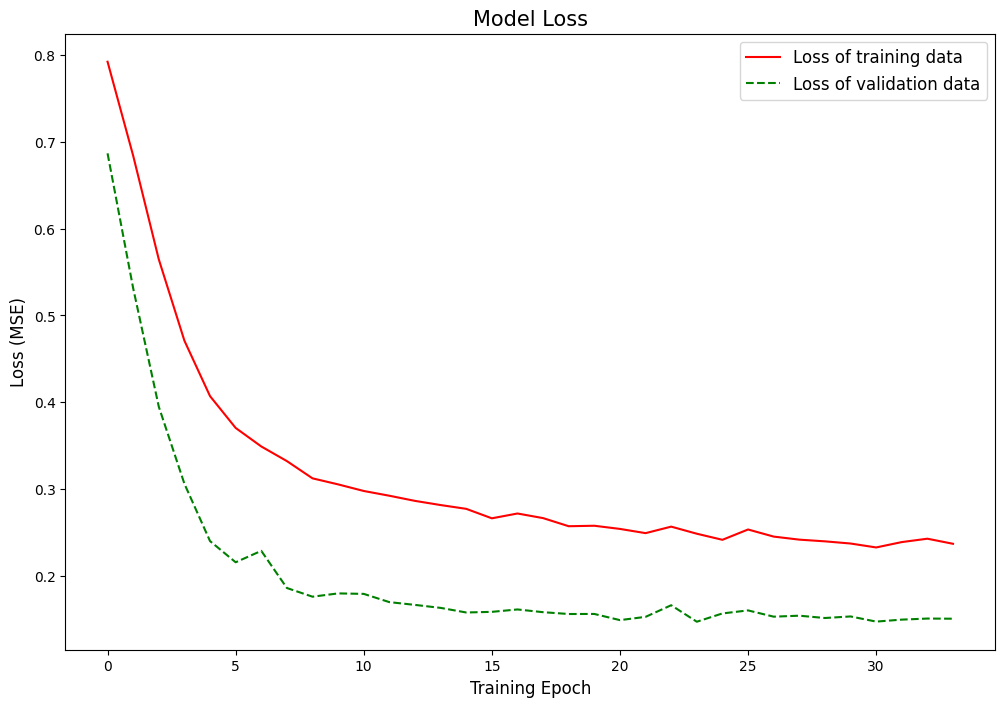

In [18]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['loss'], "r", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "g--", label="Loss of validation data", antialiased=True)
plt.title('Model Loss',fontsize=15)                                            
plt.ylabel('Loss (MSE)', fontsize=12)                                                 
plt.xlabel('Training Epoch', fontsize=12)                                                                                                                       
plt.legend(fontsize=12)                                                                    
plt.show()     

In [19]:
#del x_train

import gc
gc.collect()

5689

In [20]:
autoencoder.save('./models/model_AE_'+str(batch_size_)+'_baseAE' + wireplane + 'plane_nu.h5')

In [21]:
#autoencoder = load_model('./models/model_AE_'+str(batch_size_)+'_mirrored_1dcnn' + wireplane + 'plane_nu.h5')

In [22]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

25/25 [==============================] - 2s 66ms/step - loss: 0.1500


0.149961456656456

In [23]:
autoencoder.evaluate(x_train_scaled, y_train_scaled, batch_size=4096)

20/20 [==============================] - 1s 64ms/step - loss: 0.1455


0.14551696181297302

In [24]:
autoencoder.evaluate(x_valid_scaled, y_valid_scaled, batch_size=4096)

5/5 [==============================] - 0s 65ms/step - loss: 0.1475


0.14750677347183228

In [25]:
#ae128 = load_model('./AE_models/model_AE_'+str(batch_size_)+'_mse' + wireplane + 'plane_nu.h5')

In [26]:
%%time
predictions = autoencoder.predict(x_test_scaled, batch_size=4096)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])



25/25 [==============================] - 2s 63ms/step
CPU times: user 6.58 s, sys: 42.2 ms, total: 6.62 s
Wall time: 1.83 s


In [27]:
from scipy import stats
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_scaled*std + mean


pred = predictions*std + mean

In [28]:
# takes in prediction of AE and for every wave assigns 0 or 1
# 0 --> predicted as noise
# 1 --> pricicted as containing some kind of signals
# note that this is crude and does not consider how close the predicted signal is from truth
def label_predictions(ae_pred_wave):
    label_ = 0
    if max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


def label_truths(wave):
    label_ = 1
    if max(abs(wave)) <= 3:
        label_ = 0
    return label_

In [29]:
pred_labels = [label_predictions(wave) for wave in pred]
truth_labels = [label_truths(t_wave) for t_wave in y_test_]

In [30]:
cnn = load_model('../ROI_finder/ROI_models/model_'+wireplane+'plane_nu_ROI.h5')
cnn_pred = cnn.predict(x_test_scaled, batch_size=4096)
cnn_pred = cnn_pred.squeeze()

25/25 [==============================] - 0s 11ms/step


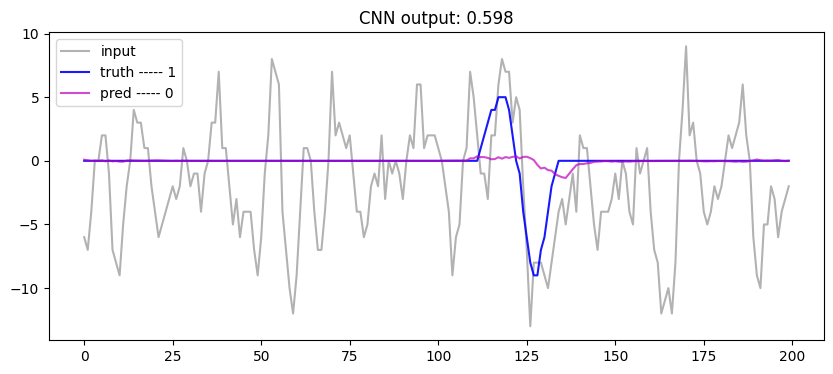

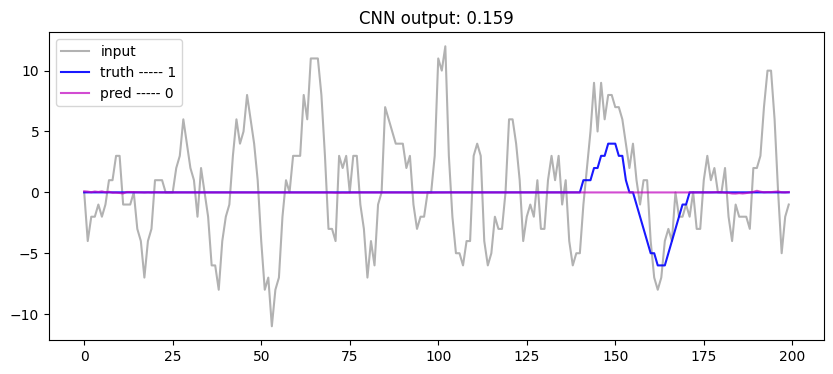

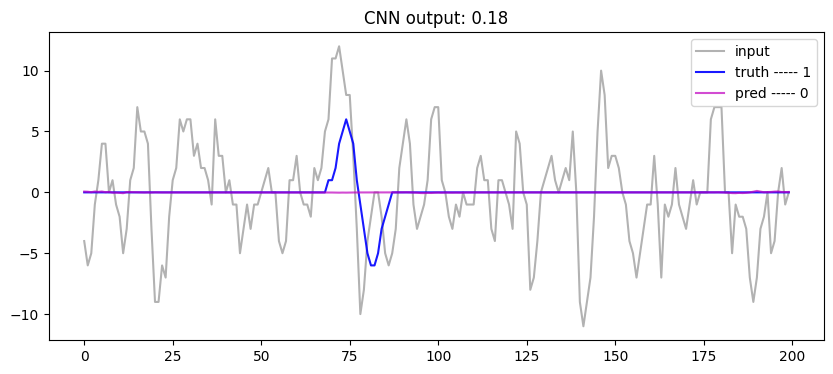

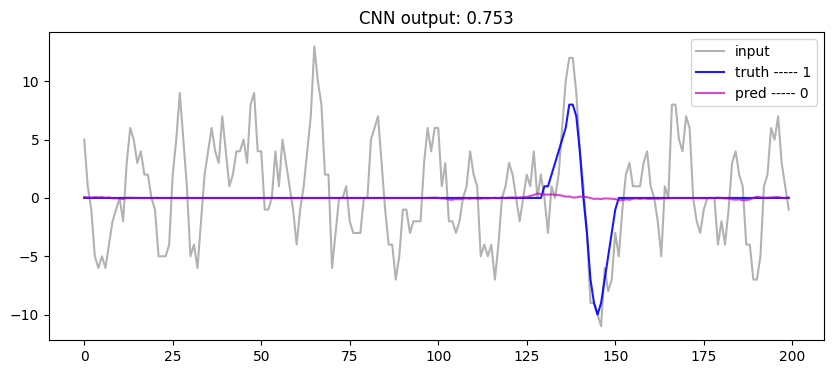

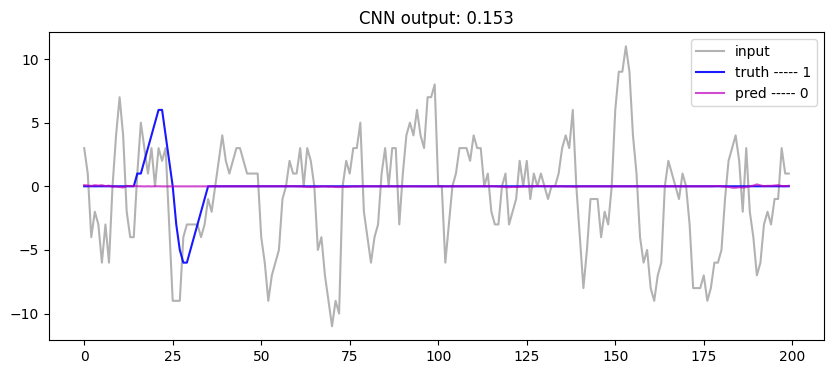

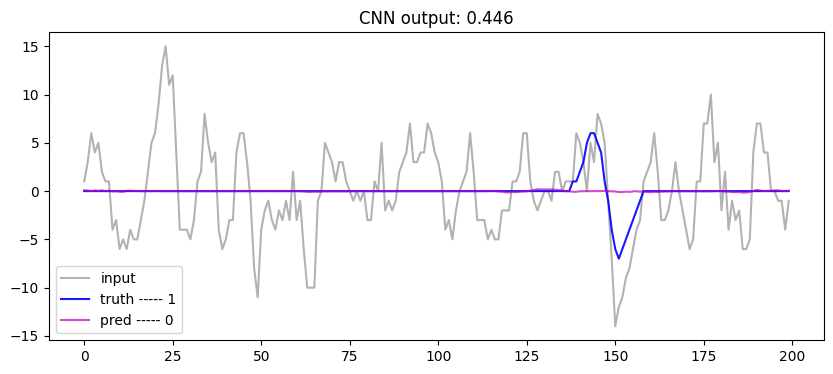

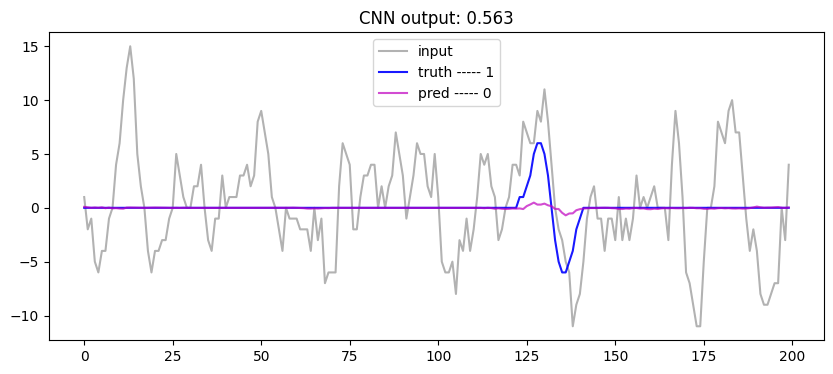

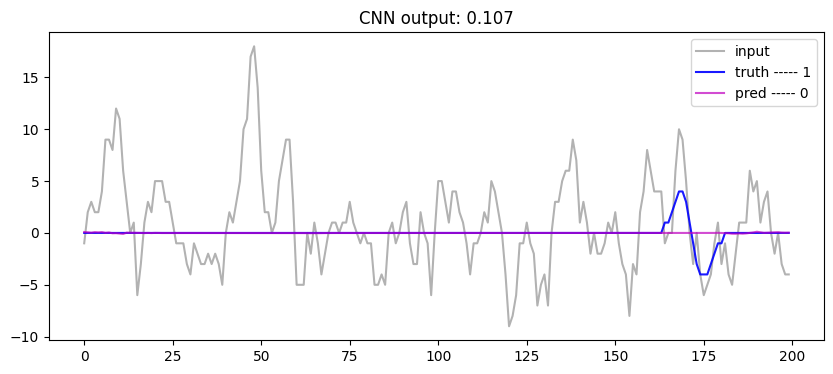

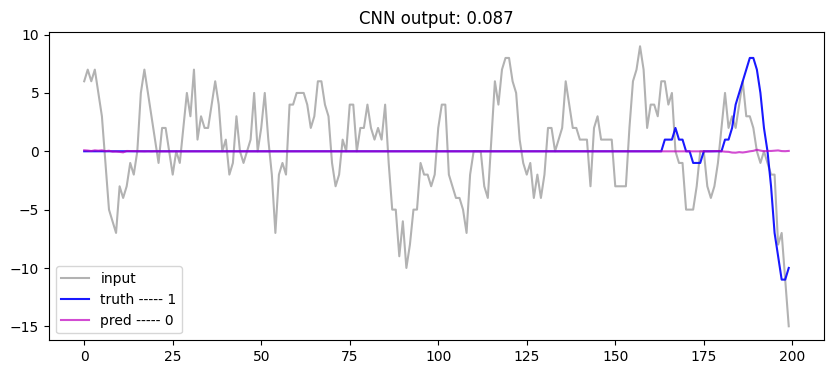

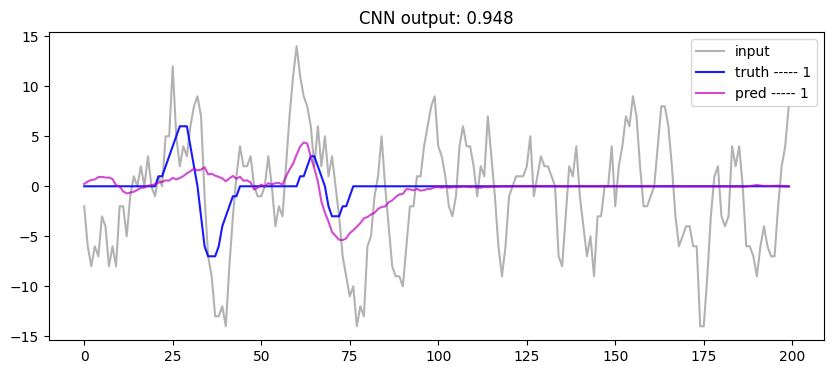

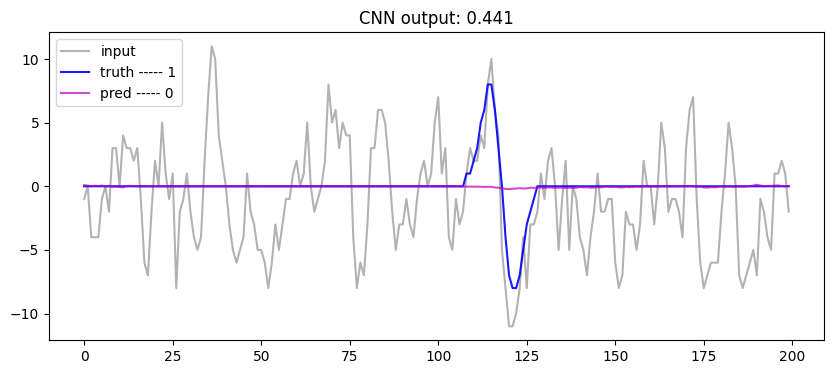

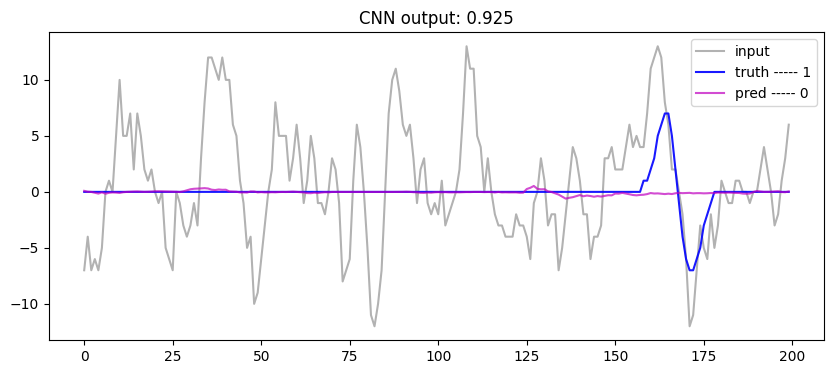

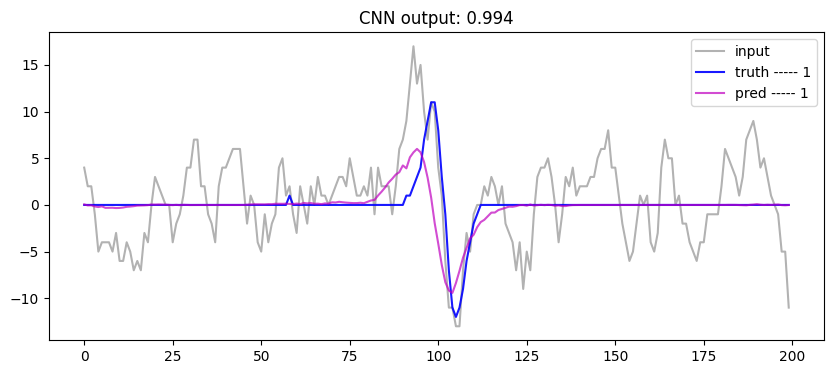

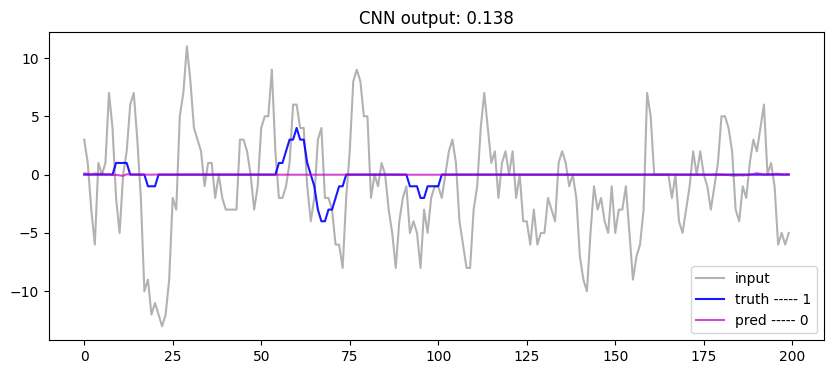

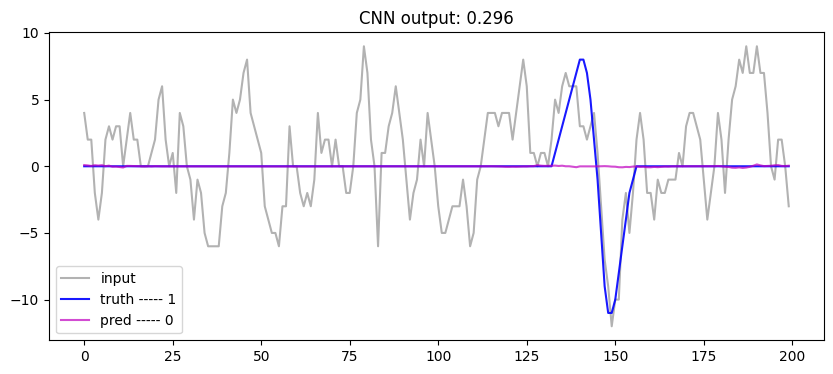

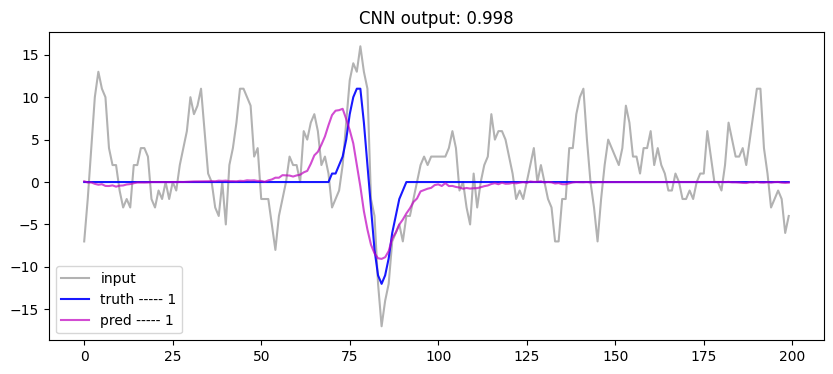

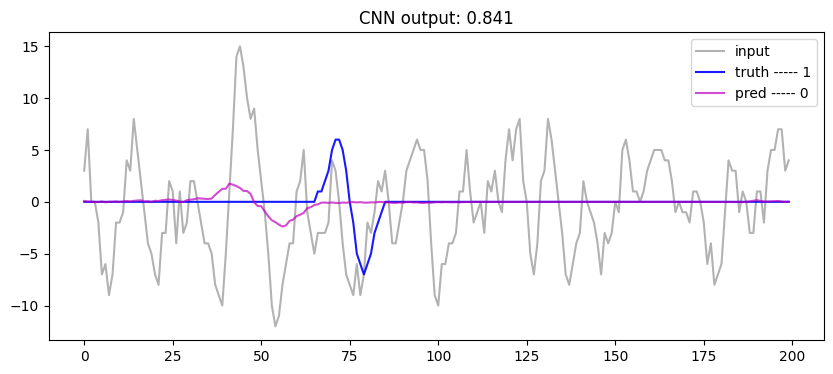

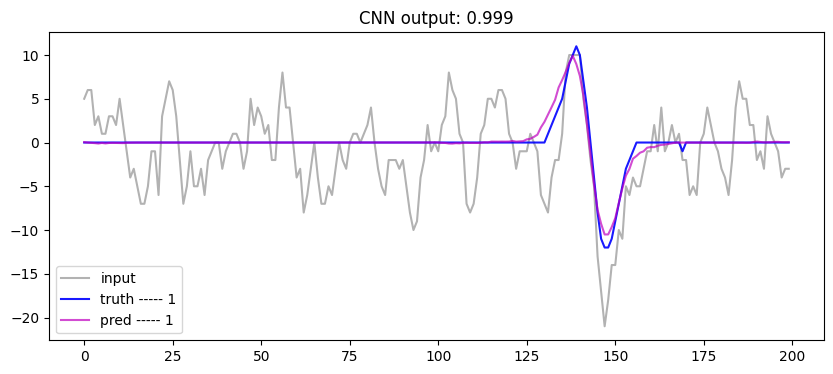

In [31]:
for i in range(100,200):
    if max(abs(y_test_[i])) < 20 and sum(abs(y_test_[i])) !=0:
        fig = plt.figure(figsize=(10,4))
        plt.plot(x_test_[i], color='black', alpha=0.3, label='input')
        plt.plot(y_test_[i], color='blue', alpha=0.9, label='truth ----- ' + str(truth_labels[i]))
        plt.plot(pred[i], color='m', alpha=0.7, label='pred ----- ' + str(pred_labels[i]))
        plt.title('CNN output: ' + str( round(cnn_pred[i], 3)))
        plt.legend()
        plt.show()


In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(truth_labels, pred_labels, drop_intermediate=False)
roc_auc = auc(fpr, tpr)


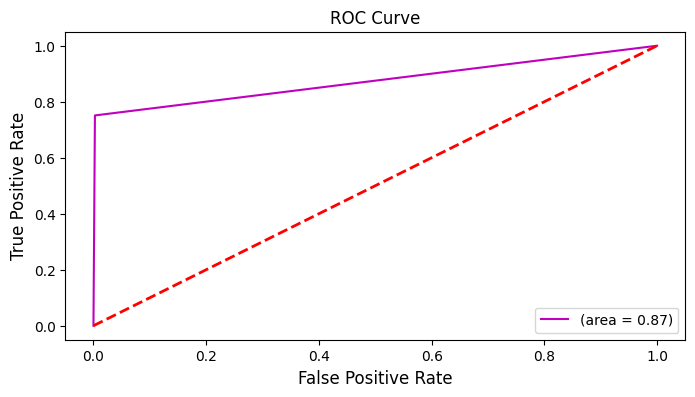

In [33]:
fig = plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='m', label='(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('ROC Curve', size=12)
plt.legend(loc="lower right")
plt.show()

In [34]:
def make_single_pdf(wave_idx, pg_num, min_cnn, max_cnn):

    fig, axs = plt.subplots(3,2, figsize=(30, 18), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        max_adc = int((max(x_test_[index_])))
        
        if not (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) != 0):
            while True:
                index_ += 1
                max_adc = int((max(x_test_[index_])))
                
                if (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) != 0):
                    break
        wave_idx = index_


        axes[i].plot(x_test_[index_], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')
        axes[i].plot(y_test_[index_],color='blue', label='target', alpha=1)
        axes[i].plot(pred[index_],color='m', label='pred', alpha=1)
        
        axes[i].legend(fontsize=12)
        axes[i].set_title('CNN output: ' + str(round(cnn_pred[index_], 4)) + ' --- [idx: ' + str(index_) + ']', size=15)
        axes[i].set_ylabel('ADC', size=12)


    plt.savefig('./plots/tmp/plts_cnn_page' + str(pg_num) +  '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx

In [35]:
# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, min_cnn, max_cnn):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, min_cnn, max_cnn) + 1
        page_num += 1

    merger = PdfMerger()
    path = './plots/tmp/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    #merger.write('pdfs/plts_tmp/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.write('./plots/'+wireplane+'/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [36]:
make_complete_pdf(10, 0.94, 1)

['./plots/tmp/plts_cnn_page2.pdf', './plots/tmp/plts_cnn_page1.pdf', './plots/tmp/plts_cnn_page9.pdf', './plots/tmp/plts_cnn_page4.pdf', './plots/tmp/plts_cnn_page6.pdf', './plots/tmp/plts_cnn_page0.pdf', './plots/tmp/plts_cnn_page7.pdf', './plots/tmp/plts_cnn_page3.pdf', './plots/tmp/plts_cnn_page8.pdf', './plots/tmp/plts_cnn_page5.pdf']


In [37]:
min_ = 0.94
prev = min_
max_ = 1
while min_ > 0:
    min_ = min_ - 0.2 
    make_complete_pdf(10, min_, prev)
    prev = min_


['./plots/tmp/plts_cnn_page2.pdf', './plots/tmp/plts_cnn_page1.pdf', './plots/tmp/plts_cnn_page9.pdf', './plots/tmp/plts_cnn_page4.pdf', './plots/tmp/plts_cnn_page6.pdf', './plots/tmp/plts_cnn_page0.pdf', './plots/tmp/plts_cnn_page7.pdf', './plots/tmp/plts_cnn_page3.pdf', './plots/tmp/plts_cnn_page8.pdf', './plots/tmp/plts_cnn_page5.pdf']
['./plots/tmp/plts_cnn_page2.pdf', './plots/tmp/plts_cnn_page1.pdf', './plots/tmp/plts_cnn_page9.pdf', './plots/tmp/plts_cnn_page4.pdf', './plots/tmp/plts_cnn_page6.pdf', './plots/tmp/plts_cnn_page0.pdf', './plots/tmp/plts_cnn_page7.pdf', './plots/tmp/plts_cnn_page3.pdf', './plots/tmp/plts_cnn_page8.pdf', './plots/tmp/plts_cnn_page5.pdf']
['./plots/tmp/plts_cnn_page2.pdf', './plots/tmp/plts_cnn_page1.pdf', './plots/tmp/plts_cnn_page9.pdf', './plots/tmp/plts_cnn_page4.pdf', './plots/tmp/plts_cnn_page6.pdf', './plots/tmp/plts_cnn_page0.pdf', './plots/tmp/plts_cnn_page7.pdf', './plots/tmp/plts_cnn_page3.pdf', './plots/tmp/plts_cnn_page8.pdf', './plots/tm